In [1]:
!pip install gensim
!pip install wordcloud
!pip install sentence-transformers
!pip install nlpaug
!pip install transformers

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns

import torch
import nltk
import re
import warnings
import string as s

from nltk.corpus import stopwords
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB 

import string

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from wordcloud import WordCloud
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from torch.utils.data import DataLoader, TensorDataset

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text  import TfidfVectorizer
from sklearn.metrics  import f1_score,accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, f1_score, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sentence_transformers import SentenceTransformer
from transformers import BertTokenizer, BertForSequenceClassification, AdamW

from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models import Word2Vec

warnings.filterwarnings("ignore")

In [3]:
train_data = pd.read_csv('/kaggle/input/ag-news-classification-dataset/train.csv', header=0, names=['ID', 'Title', 'Desc'])
test_data = pd.read_csv('/kaggle/input/ag-news-classification-dataset/test.csv', header=0, names=['ID', 'Title', 'Desc'])

train_data = train_data.groupby('ID').apply(lambda x: x.sample(n=5000, random_state=42)).reset_index(drop=True)
test_data = test_data.groupby('ID').apply(lambda x: x.sample(n=1000, random_state=42)).reset_index(drop=True)

print(f"Training set shape: {train_data.shape}")
print(f"Test set shape: {test_data.shape}")

Training set shape: (20000, 3)
Test set shape: (4000, 3)


In [4]:
train_data.head()

,ID,Title,Desc
0,1,Explosion Rocks Baghdad Neighborhood,"BAGHDAD, Iraq, August 24 -- A car bomb explode..."
1,1,BBC reporters' log,BBC correspondents record events in the Middle...
2,1,Israel welcomes Rice nomination; Palestinians ...,Israel on Tuesday warmly welcomed the naming o...
3,1,Medical Journal Calls for a New Drug Watchdog,Medical researchers said the U.S. needs a syst...
4,1,Militants Kidnap Relatives of Iraqi Minister-TV,Militants have kidnapped two relatives of Iraq...


In [5]:
test_data.head()

,ID,Title,Desc
0,1,Large Explosion Heard in Central Baghdad (Reut...,Reuters - A large blast was heard in central\B...
1,1,Israel OKs More West Bank Settlement Homes,"JERUSALEM Aug. 23, 2004 - Israel announced pla..."
2,1,Scores of Iraqis die in 3 days of attacks,US troops fought a gunbattle with insurgents a...
3,1,At least 20 dead in Kurkik bombing,A suicide attacker detonated a car bomb near a...
4,1,"Israel, Egypt in Prisoner Swap",CAIRO (Reuters) - Israel released six Egyptia...


In [6]:
print(train_data.shape)
print(test_data.shape)

(20000, 3)
(4000, 3)


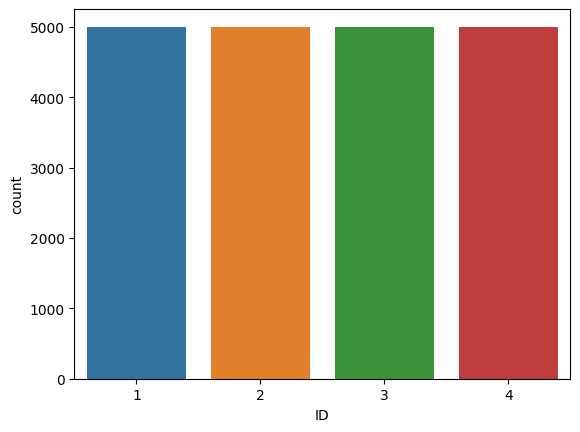

In [7]:
sns.countplot(x = 'ID', data = train_data)
plt.show()

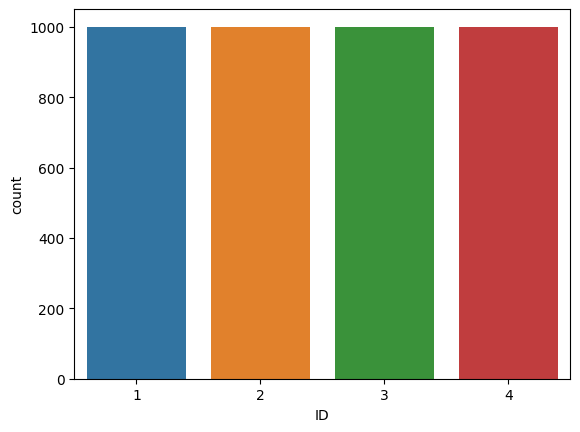

In [8]:
sns.countplot(x = 'ID', data = test_data)
plt.show()

In [9]:
train_x = train_data.Desc
test_x = test_data.Desc
train_y = train_data.ID
test_y = test_data.ID

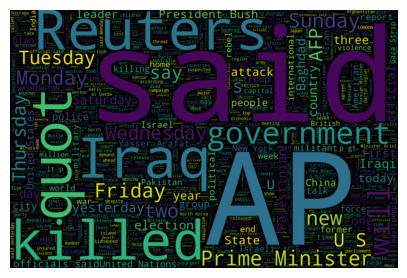

In [10]:
world = train_data[train_data['ID'] == 1]['Desc']
plt.figure(figsize=(5, 5))
wordcloud = WordCloud(min_font_size=3, max_words=2500, width=1200, height=800).generate(" ".join(world))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

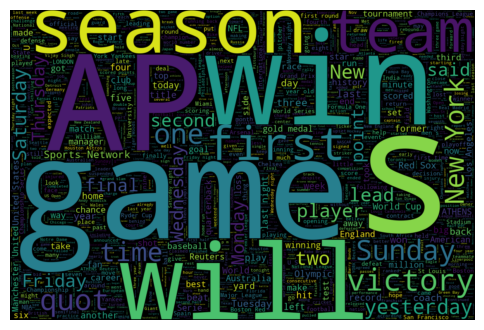

In [11]:
sports_desc = train_data.loc[train_data['ID'] == 2, 'Desc']
plt.figure(figsize=(6, 6))
wordcloud = WordCloud(min_font_size=3, max_words=2500, width=1200, height=800).generate(" ".join(sports_desc))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

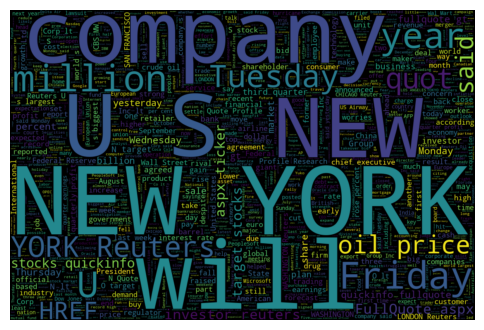

In [12]:
biz_desc = train_data.loc[train_data['ID'] == 3, 'Desc']
plt.figure(figsize=(6, 6))
wordcloud = WordCloud(min_font_size=3, max_words=2500, width=1200, height=800).generate(" ".join(biz_desc))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

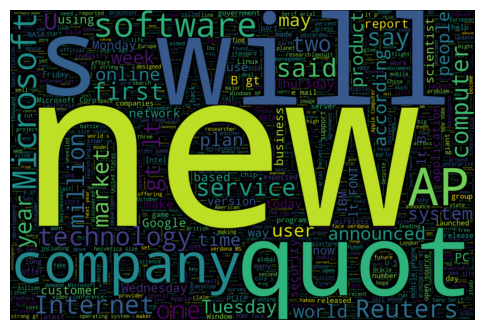

In [13]:
sci_desc = train_data.loc[train_data['ID'] == 4, 'Desc']
plt.figure(figsize=(6, 6))
wordcloud = WordCloud(min_font_size=3, max_words=2500, width=1200, height=800).generate(" ".join(sci_desc))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [14]:
def remove_html_tag(text):
    html = re.compile('<.*?')
    cleaned_text = html.sub('', text)
    return cleaned_text
train_x = train_x.apply(remove_html_tag)
test_x = test_x.apply(remove_html_tag)

In [15]:
def url_remove(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)
train_x = train_x.apply(url_remove)
test_x = test_x.apply(url_remove)

In [16]:
def word_tokenize(text):
    token = re.findall("[\w']+", text)
    return token
train_x = train_x.apply(word_tokenize)
test_x = test_x.apply(word_tokenize)

In [17]:
train_x = train_x.apply(lambda x: [word.lower() for word in x])
test_x = test_x.apply(lambda x: [word.lower() for word in x])

In [18]:
def remove_stopwords(lst):
    stop_words = set(stopwords.words('english'))
    return [word for word in lst if word.lower() not in stop_words]
train_x = train_x.apply(remove_stopwords)
test_x = test_x.apply(remove_stopwords)

In [19]:
def remove_punctuations(lst):
    return [''.join(char for char in word if char not in string.punctuation) for word in lst]
train_x = train_x.apply(remove_punctuations)
test_x = test_x.apply(remove_punctuations)

In [20]:
def remove_number(lst):
    return [''.join(char for char in word if char not in string.digits) for word in lst if word]
train_x = train_x.apply(remove_number)
test_x = test_x.apply(remove_number)

In [21]:
def stemming(text):
    porter_stemmer = PorterStemmer()
    return [porter_stemmer.stem(word) for word in text]
train_x = train_x.apply(stemming)
test_x = test_x.apply(stemming)

In [22]:
def remove_extra_words(word_list):
    stopwords = ['href', 'lt', 'gt', 'ii', 'iii', 'ie', 'quot', 'com']
    cleaned_list = []
    for word in word_list:
        if word not in stopwords:
            cleaned_list.append(word)
    return cleaned_list
train_x = train_x.apply(remove_extra_words)
test_x = test_x.apply(remove_extra_words)

In [23]:
def join_words_with_space(sentence):
    joined_sentence = ' '.join(sentence)
    return joined_sentence

train_x = train_x.apply(join_words_with_space)
test_x = test_x.apply(join_words_with_space)

In [24]:
def apply_tfidf_embeddings(train_x, test_x):
    tfidf = TfidfVectorizer(max_features=5000)
    train_tfidf = tfidf.fit_transform(train_x)
    test_tfidf = tfidf.transform(test_x)
    
    return train_tfidf, test_tfidf


In [25]:
def apply_sbert_embeddings(train_x, test_x):
    model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
    train_sbert = model.encode(train_x.tolist(), convert_to_tensor=True)
    test_sbert = model.encode(test_x.tolist(), convert_to_tensor=True)
    
    return train_sbert, test_sbert


In [26]:
def apply_doc2vec_embeddings(train_x, test_x):
    train_documents = [TaggedDocument(words=sentence.split(), tags=[str(i)]) for i, sentence in enumerate(train_x)]
    test_documents = [TaggedDocument(words=sentence.split(), tags=[str(i)]) for i, sentence in enumerate(test_x)]
    
    model = Doc2Vec(vector_size=300, window=2, min_count=1, workers=4, epochs=40)
    model.build_vocab(train_documents)
    model.train(train_documents, total_examples=model.corpus_count, epochs=model.epochs)
    
    train_doc2vec = [model.infer_vector(sentence.words) for sentence in train_documents]
    test_doc2vec = [model.infer_vector(sentence.words) for sentence in test_documents]
    
    return train_doc2vec, test_doc2vec


In [27]:
def apply_word2vec_embeddings(train_x, test_x):
    sentences_train = [sentence.split() for sentence in train_x]
    sentences_test = [sentence.split() for sentence in test_x]
    
    model = Word2Vec(sentences_train, vector_size=300, window=5, min_count=1, workers=4)
    model.save("word2vec.model")
    
    def get_average_word2vec(sentence):
        words = sentence.split()
        word_vectors = [model.wv[word] for word in words if word in model.wv]
        return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(model.vector_size)

    train_word2vec = np.array([get_average_word2vec(sentence) for sentence in train_x])
    test_word2vec = np.array([get_average_word2vec(sentence) for sentence in test_x])
    
    return train_word2vec, test_word2vec


In [28]:
# Class names mapping
class_names = {
    0: "World",
    1: "Sports",
    2: "Business",
    3: "Science/Tech"
}

def evaluate_model(model, embeddings_test, test_y):
    # Make predictions on the test set
    y_pred = model.predict(embeddings_test)

    # Print accuracy
    print(f"Accuracy is: {accuracy_score(test_y, y_pred)}")
    
    # Print classification report
    print("Classification Report:")
    print(classification_report(test_y, y_pred, target_names=[class_names[i] for i in np.unique(test_y)]))
    
    # Plot confusion matrix
    conf_matrix = confusion_matrix(test_y, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[class_names[i] for i in np.unique(test_y)])
    disp.plot(cmap="Blues", values_format="d")
    plt.title("Confusion Matrix")
    plt.show()

    # Print misclassified examples
    misclassified_indices = np.where(y_pred != test_y)[0]
    print("Misclassified Texts:")
    for idx in misclassified_indices[:5]:  # Print the first 5 misclassified samples
        print(f"Predicted: {class_names[int(y_pred[idx])]}, Actual: {class_names[int(test_y[idx])]}")
        print(f"Text: {test_x.iloc[idx]}")  # Ensure `test_x` is indexed correctly
        print("-" * 50)


In [29]:
train_tfidf, test_tfidf = apply_tfidf_embeddings(train_x, test_x)
train_sbert, test_sbert = apply_sbert_embeddings(train_x, test_x)
train_doc2vec, test_doc2vec = apply_doc2vec_embeddings(train_x, test_x)
train_word2vec, test_word2vec = apply_word2vec_embeddings(train_x, test_x)

Batches:   0%|          | 0/625 [00:00<?, ?it/s]

Batches:   0%|          | 0/125 [00:00<?, ?it/s]

In [30]:
label_encoder = LabelEncoder()

train_y = label_encoder.fit_transform(train_y)
test_y = label_encoder.transform(test_y)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

### Word2Vec

Accuracy is: 0.75075
Classification Report:
              precision    recall  f1-score   support

       World       0.78      0.76      0.77      1000
      Sports       0.78      0.85      0.81      1000
    Business       0.72      0.71      0.72      1000
Science/Tech       0.71      0.68      0.70      1000

    accuracy                           0.75      4000
   macro avg       0.75      0.75      0.75      4000
weighted avg       0.75      0.75      0.75      4000



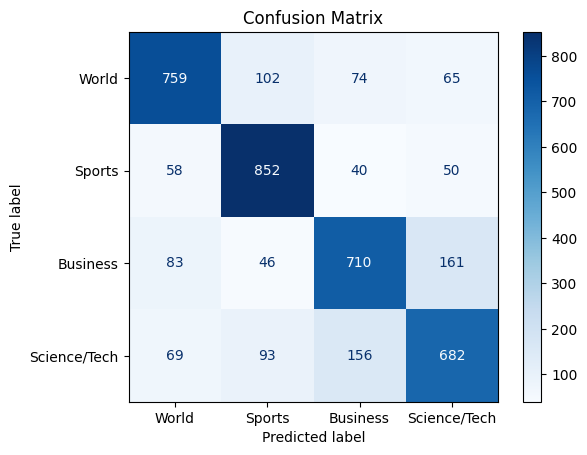

Misclassified Texts:
Predicted: Sports, Actual: World
Text: mep threaten last night bring new european commiss even take offic row spark controversi comment homosexu escal unpreced crisi
--------------------------------------------------
Predicted: Business, Actual: World
Text: near daili attack pipelin pump station push iraq  oil export lowest point nearli year britain  financi time newspap report today
--------------------------------------------------
Predicted: Sports, Actual: World
Text: reuter govern warplan helicopt gunship pound rebel held town northern ivori coast second day friday fuel fear slide war world top cocoa grower
--------------------------------------------------
Predicted: Science/Tech, Actual: World
Text: dup leader ian paisley discuss head independ decommiss bodi iicd issu put ira weapon beyond use
--------------------------------------------------
Predicted: Sports, Actual: World
Text: dup last night reconsid boycott talk irish govern taoiseach berti ahern apolo

In [31]:
xgb_model = XGBClassifier(tree_method="gpu_hist", predictor="gpu_predictor", use_label_encoder=True, eval_metric="mlogloss")

# To store final model (trained on full training data during each fold)
for train_index, val_index in kf.split(train_word2vec):
    X_train, X_val = train_word2vec[train_index], train_word2vec[val_index]
    y_train, y_val = train_y[train_index], train_y[val_index]
    
    # Train the model using KFold
    xgb_model.fit(X_train, y_train)

# After training with K-fold, make predictions on the test set
evaluate_model(xgb_model, test_word2vec, test_y)

Accuracy is: 0.725
Classification Report:
              precision    recall  f1-score   support

       World       0.74      0.75      0.75      1000
      Sports       0.75      0.83      0.79      1000
    Business       0.71      0.68      0.69      1000
Science/Tech       0.69      0.64      0.67      1000

    accuracy                           0.73      4000
   macro avg       0.72      0.73      0.72      4000
weighted avg       0.72      0.72      0.72      4000



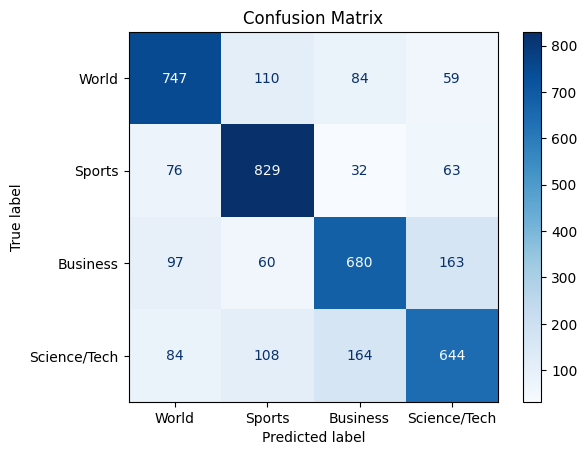

Misclassified Texts:
Predicted: Sports, Actual: World
Text: mep threaten last night bring new european commiss even take offic row spark controversi comment homosexu escal unpreced crisi
--------------------------------------------------
Predicted: Business, Actual: World
Text: near daili attack pipelin pump station push iraq  oil export lowest point nearli year britain  financi time newspap report today
--------------------------------------------------
Predicted: Business, Actual: World
Text: reuter govern warplan helicopt gunship pound rebel held town northern ivori coast second day friday fuel fear slide war world top cocoa grower
--------------------------------------------------
Predicted: Science/Tech, Actual: World
Text: dup leader ian paisley discuss head independ decommiss bodi iicd issu put ira weapon beyond use
--------------------------------------------------
Predicted: Business, Actual: World
Text: kirkuk iraq nov  afp iraqi oil export turkey halt seri attack tuesday inc

In [32]:
rf_model = RandomForestClassifier()

# To store final model (trained on full training data during each fold)
for train_index, val_index in kf.split(train_word2vec):
    X_train, X_val = train_word2vec[train_index], train_word2vec[val_index]
    y_train, y_val = train_y[train_index], train_y[val_index]
    
    # Train the model using KFold
    rf_model.fit(X_train, y_train)

# After training with K-fold, make predictions on the test set
evaluate_model(rf_model, test_word2vec, test_y)

Accuracy is: 0.745
Classification Report:
              precision    recall  f1-score   support

       World       0.78      0.76      0.77      1000
      Sports       0.77      0.85      0.81      1000
    Business       0.73      0.70      0.71      1000
Science/Tech       0.70      0.68      0.69      1000

    accuracy                           0.74      4000
   macro avg       0.74      0.75      0.74      4000
weighted avg       0.74      0.74      0.74      4000



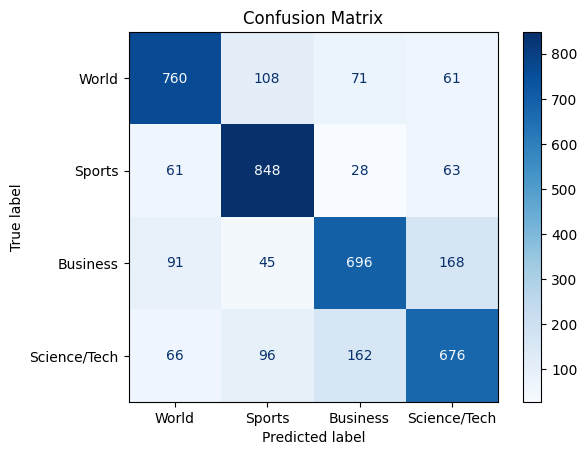

Misclassified Texts:
Predicted: World, Actual: World
Text: reuter larg blast heard central baghdad thursday wit said
--------------------------------------------------
Predicted: World, Actual: World
Text: reuter larg blast heard central baghdad thursday wit said
--------------------------------------------------
Predicted: World, Actual: World
Text: reuter larg blast heard central baghdad thursday wit said
--------------------------------------------------
Predicted: World, Actual: World
Text: reuter larg blast heard central baghdad thursday wit said
--------------------------------------------------
Predicted: World, Actual: World
Text: reuter larg blast heard central baghdad thursday wit said
--------------------------------------------------


In [33]:
# Initialize CatBoost model with GPU support
catboost_model = CatBoostClassifier(
    iterations=1000, 
    learning_rate=0.1, 
    depth=6,
    task_type="GPU",  # Use GPU
    loss_function='MultiClass',
    eval_metric='Accuracy',
    cat_features=[],
    verbose=0
)


# To store final model (trained on full training data during each fold)
for train_index, val_index in kf.split(train_word2vec):
    X_train, X_val = train_word2vec[train_index], train_word2vec[val_index]
    y_train, y_val = train_y[train_index], train_y[val_index]
    
    # Train the model using KFold
    catboost_model.fit(X_train, y_train)

# After training with K-fold, make predictions on the test set
evaluate_model(catboost_model, test_word2vec, test_y)

Accuracy is: 0.752
Classification Report:
              precision    recall  f1-score   support

       World       0.78      0.76      0.77      1000
      Sports       0.78      0.86      0.81      1000
    Business       0.73      0.71      0.72      1000
Science/Tech       0.72      0.68      0.70      1000

    accuracy                           0.75      4000
   macro avg       0.75      0.75      0.75      4000
weighted avg       0.75      0.75      0.75      4000



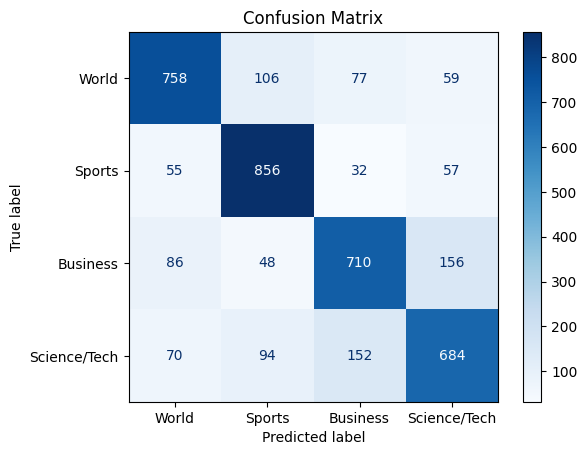

Misclassified Texts:
Predicted: Sports, Actual: World
Text: mep threaten last night bring new european commiss even take offic row spark controversi comment homosexu escal unpreced crisi
--------------------------------------------------
Predicted: Business, Actual: World
Text: near daili attack pipelin pump station push iraq  oil export lowest point nearli year britain  financi time newspap report today
--------------------------------------------------
Predicted: Sports, Actual: World
Text: reuter govern warplan helicopt gunship pound rebel held town northern ivori coast second day friday fuel fear slide war world top cocoa grower
--------------------------------------------------
Predicted: Science/Tech, Actual: World
Text: dup leader ian paisley discuss head independ decommiss bodi iicd issu put ira weapon beyond use
--------------------------------------------------
Predicted: Sports, Actual: World
Text: islamabad nov  nnn pakistan lead newspap dawn find time indian announc reduct

In [34]:
# Create a Voting Classifier (soft voting)
voting_clf = VotingClassifier(
    estimators=[('xgb', xgb_model), ('rf', rf_model), ('catboost', catboost_model)],
    voting='soft'  # Soft voting (based on predicted probabilities)
)

# To store final model (trained on full training data during each fold)
for train_index, val_index in kf.split(train_word2vec):
    X_train, X_val = train_word2vec[train_index], train_word2vec[val_index]
    y_train, y_val = train_y[train_index], train_y[val_index]
    
    # Train the model using KFold
    voting_clf.fit(X_train, y_train)

# After training with K-fold, make predictions on the test set
evaluate_model(voting_clf, test_word2vec, test_y)

### TFIDF Embeddings

Accuracy is: 0.4295
Classification Report:
              precision    recall  f1-score   support

       World       0.93      0.21      0.35      1000
      Sports       0.82      0.46      0.59      1000
    Business       0.86      0.12      0.20      1000
Science/Tech       0.30      0.93      0.45      1000

    accuracy                           0.43      4000
   macro avg       0.73      0.43      0.40      4000
weighted avg       0.73      0.43      0.40      4000



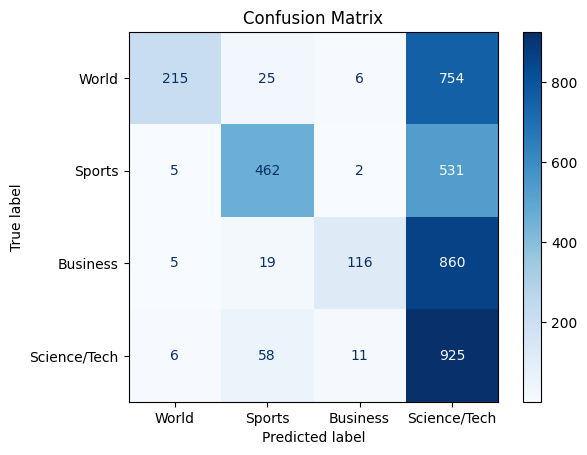

Misclassified Texts:
Predicted: Science/Tech, Actual: World
Text: reuter larg blast heard central baghdad thursday wit said
--------------------------------------------------
Predicted: Science/Tech, Actual: World
Text: jerusalem aug   israel announc plan monday build hundr new hous unit west bank follow appar us polici shift settlement palestinian warn destroy peac process
--------------------------------------------------
Predicted: Science/Tech, Actual: World
Text: cairo reuter israel releas six egyptian student prison sunday part deal includ freedom isra businessman convict spi azzam azzam egyptian secur sourc said
--------------------------------------------------
Predicted: Science/Tech, Actual: World
Text: mep threaten last night bring new european commiss even take offic row spark controversi comment homosexu escal unpreced crisi
--------------------------------------------------
Predicted: Science/Tech, Actual: World
Text: reuter govern warplan helicopt gunship pound rebel hel

In [35]:
# To store final model (trained on full training data during each fold)
for train_index, val_index in kf.split(train_tfidf):
    X_train, X_val = train_tfidf[train_index], train_tfidf[val_index]
    y_train, y_val = train_y[train_index], train_y[val_index]
    
    # Train the model using KFold
    xgb_model.fit(X_train, y_train)

# After training with K-fold, make predictions on the test set
evaluate_model(xgb_model, test_tfidf, test_y)

Accuracy is: 0.8395
Classification Report:
              precision    recall  f1-score   support

       World       0.85      0.83      0.84      1000
      Sports       0.88      0.93      0.91      1000
    Business       0.81      0.80      0.81      1000
Science/Tech       0.82      0.79      0.80      1000

    accuracy                           0.84      4000
   macro avg       0.84      0.84      0.84      4000
weighted avg       0.84      0.84      0.84      4000



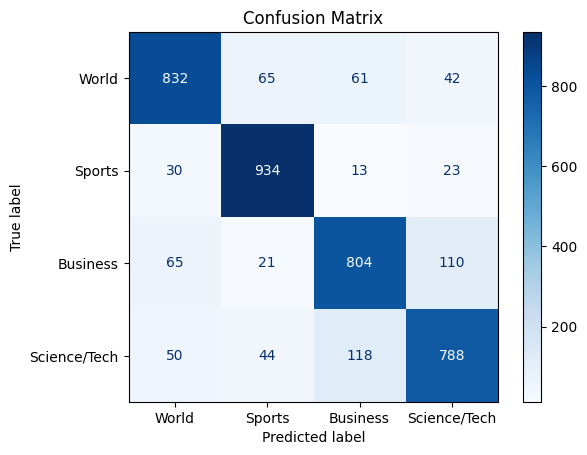

Misclassified Texts:
Predicted: Sports, Actual: World
Text: mep threaten last night bring new european commiss even take offic row spark controversi comment homosexu escal unpreced crisi
--------------------------------------------------
Predicted: Sports, Actual: World
Text: thousand disgruntl vacation strand heathrow airport tuesday british airway cancel score flight staff shortag technic hitch
--------------------------------------------------
Predicted: Business, Actual: World
Text: ankara turkey hope attract  billion foreign invest   reform design overhaul economi eas countri  entri
--------------------------------------------------
Predicted: Science/Tech, Actual: World
Text: hayley mick journalist current base vancouv broadcast experi cbc radio  quirk quark report vancouv sun cbc onlin canadian press  ontario vancouv bureau
--------------------------------------------------
Predicted: Business, Actual: World
Text: afp eu transport energi commission loyola de palacio hail accord 

In [36]:
# To store final model (trained on full training data during each fold)
for train_index, val_index in kf.split(train_tfidf):
    X_train, X_val = train_tfidf[train_index], train_tfidf[val_index]
    y_train, y_val = train_y[train_index], train_y[val_index]
    
    # Train the model using KFold
    rf_model.fit(X_train, y_train)

# After training with K-fold, make predictions on the test set
evaluate_model(rf_model, test_tfidf, test_y)

Accuracy is: 0.85825
Classification Report:
              precision    recall  f1-score   support

       World       0.86      0.85      0.86      1000
      Sports       0.88      0.95      0.91      1000
    Business       0.84      0.81      0.83      1000
Science/Tech       0.85      0.82      0.83      1000

    accuracy                           0.86      4000
   macro avg       0.86      0.86      0.86      4000
weighted avg       0.86      0.86      0.86      4000



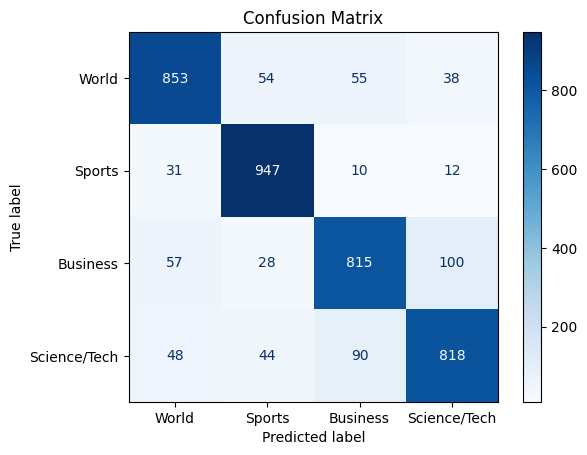

Misclassified Texts:
Predicted: World, Actual: World
Text: reuter larg blast heard central baghdad thursday wit said
--------------------------------------------------
Predicted: World, Actual: World
Text: reuter larg blast heard central baghdad thursday wit said
--------------------------------------------------
Predicted: World, Actual: World
Text: reuter larg blast heard central baghdad thursday wit said
--------------------------------------------------
Predicted: World, Actual: World
Text: reuter larg blast heard central baghdad thursday wit said
--------------------------------------------------
Predicted: World, Actual: World
Text: reuter larg blast heard central baghdad thursday wit said
--------------------------------------------------


In [37]:
# To store final model (trained on full training data during each fold)
for train_index, val_index in kf.split(train_tfidf):
    X_train, X_val = train_tfidf[train_index], train_tfidf[val_index]
    y_train, y_val = train_y[train_index], train_y[val_index]
    
    # Train the model using KFold
    catboost_model.fit(X_train, y_train)

# After training with K-fold, make predictions on the test set
evaluate_model(catboost_model, test_tfidf, test_y)

Accuracy is: 0.85225
Classification Report:
              precision    recall  f1-score   support

       World       0.87      0.84      0.86      1000
      Sports       0.89      0.94      0.91      1000
    Business       0.84      0.81      0.83      1000
Science/Tech       0.81      0.81      0.81      1000

    accuracy                           0.85      4000
   macro avg       0.85      0.85      0.85      4000
weighted avg       0.85      0.85      0.85      4000



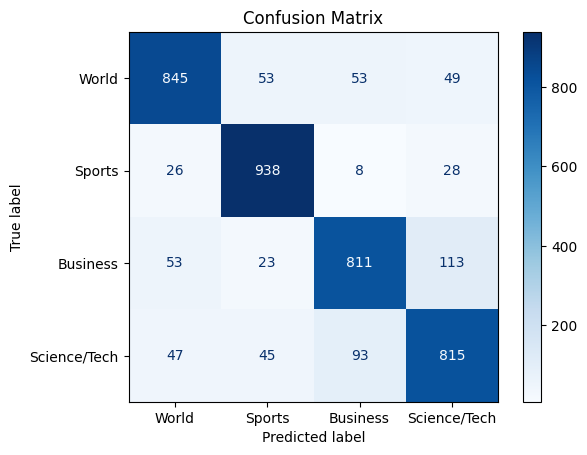

Misclassified Texts:
Predicted: Sports, Actual: World
Text: mep threaten last night bring new european commiss even take offic row spark controversi comment homosexu escal unpreced crisi
--------------------------------------------------
Predicted: Sports, Actual: World
Text: thousand disgruntl vacation strand heathrow airport tuesday british airway cancel score flight staff shortag technic hitch
--------------------------------------------------
Predicted: Business, Actual: World
Text: ankara turkey hope attract  billion foreign invest   reform design overhaul economi eas countri  entri
--------------------------------------------------
Predicted: Science/Tech, Actual: World
Text: hayley mick journalist current base vancouv broadcast experi cbc radio  quirk quark report vancouv sun cbc onlin canadian press  ontario vancouv bureau
--------------------------------------------------
Predicted: Business, Actual: World
Text: afp eu transport energi commission loyola de palacio hail accord 

In [38]:
# To store final model (trained on full training data during each fold)
for train_index, val_index in kf.split(train_tfidf):
    X_train, X_val = train_tfidf[train_index], train_tfidf[val_index]
    y_train, y_val = train_y[train_index], train_y[val_index]
    
    # Train the model using KFold
    voting_clf.fit(X_train, y_train)

# After training with K-fold, make predictions on the test set
evaluate_model(voting_clf, test_tfidf, test_y)

### Bert

Accuracy is: 0.84225
Classification Report:
              precision    recall  f1-score   support

       World       0.87      0.83      0.85      1000
      Sports       0.92      0.92      0.92      1000
    Business       0.78      0.79      0.78      1000
Science/Tech       0.81      0.82      0.81      1000

    accuracy                           0.84      4000
   macro avg       0.84      0.84      0.84      4000
weighted avg       0.84      0.84      0.84      4000



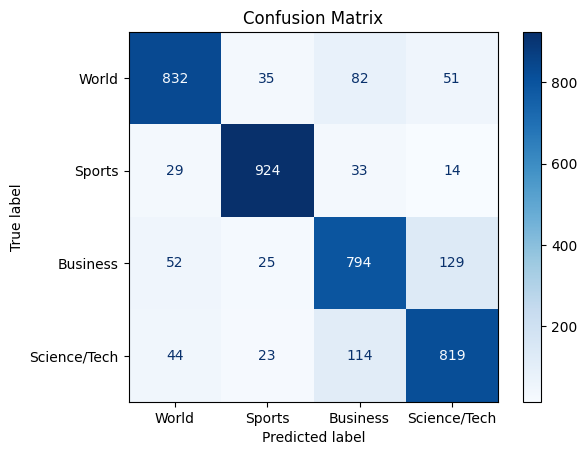

Misclassified Texts:
Predicted: Science/Tech, Actual: World
Text: mep threaten last night bring new european commiss even take offic row spark controversi comment homosexu escal unpreced crisi
--------------------------------------------------
Predicted: Sports, Actual: World
Text: thousand disgruntl vacation strand heathrow airport tuesday british airway cancel score flight staff shortag technic hitch
--------------------------------------------------
Predicted: Business, Actual: World
Text: ankara turkey hope attract  billion foreign invest   reform design overhaul economi eas countri  entri
--------------------------------------------------
Predicted: Science/Tech, Actual: World
Text: hayley mick journalist current base vancouv broadcast experi cbc radio  quirk quark report vancouv sun cbc onlin canadian press  ontario vancouv bureau
--------------------------------------------------
Predicted: Business, Actual: World
Text: kuala lumpur malaysia convey thai prime minist thaksin shin

In [46]:
# Check if test_sbert is a CUDA tensor (on GPU)
if isinstance(test_sbert, torch.Tensor) or isinstance(train_sbert, torch.Tensor):
    # Move the tensor to CPU and detach it before converting to numpy
    train_sbert = train_sbert.to('cpu').detach().numpy()
    test_sbert = test_sbert.to('cpu').detach().numpy()

# To store final model (trained on full training data during each fold)
for train_index, val_index in kf.split(train_sbert):
    X_train, X_val = train_sbert[train_index], train_sbert[val_index]
    y_train, y_val = train_y[train_index], train_y[val_index]
    
    # Train the model using KFold
    xgb_model.fit(X_train, y_train)

# After training with K-fold, make predictions on the test set
evaluate_model(xgb_model, test_sbert, test_y)

Accuracy is: 0.821
Classification Report:
              precision    recall  f1-score   support

       World       0.83      0.83      0.83      1000
      Sports       0.88      0.90      0.89      1000
    Business       0.76      0.79      0.77      1000
Science/Tech       0.81      0.77      0.79      1000

    accuracy                           0.82      4000
   macro avg       0.82      0.82      0.82      4000
weighted avg       0.82      0.82      0.82      4000



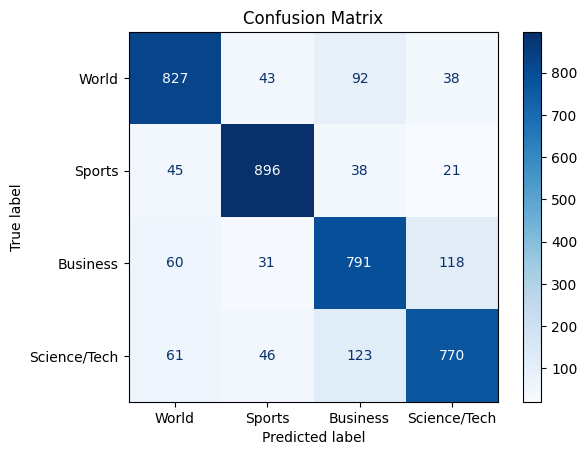

Misclassified Texts:
Predicted: Science/Tech, Actual: World
Text: mep threaten last night bring new european commiss even take offic row spark controversi comment homosexu escal unpreced crisi
--------------------------------------------------
Predicted: Business, Actual: World
Text: thousand disgruntl vacation strand heathrow airport tuesday british airway cancel score flight staff shortag technic hitch
--------------------------------------------------
Predicted: Business, Actual: World
Text: ankara turkey hope attract  billion foreign invest   reform design overhaul economi eas countri  entri
--------------------------------------------------
Predicted: Sports, Actual: World
Text: hayley mick journalist current base vancouv broadcast experi cbc radio  quirk quark report vancouv sun cbc onlin canadian press  ontario vancouv bureau
--------------------------------------------------
Predicted: Science/Tech, Actual: World
Text: australian ian previt found guilti queensland juri murder  

In [47]:
# To store final model (trained on full training data during each fold)
for train_index, val_index in kf.split(train_sbert):
    X_train, X_val = train_sbert[train_index], train_sbert[val_index]
    y_train, y_val = train_y[train_index], train_y[val_index]
    
    # Train the model using KFold
    rf_model.fit(X_train, y_train)

# After training with K-fold, make predictions on the test set
evaluate_model(rf_model, test_sbert, test_y)

Accuracy is: 0.84425
Classification Report:
              precision    recall  f1-score   support

       World       0.85      0.84      0.85      1000
      Sports       0.93      0.91      0.92      1000
    Business       0.78      0.80      0.79      1000
Science/Tech       0.82      0.81      0.82      1000

    accuracy                           0.84      4000
   macro avg       0.84      0.84      0.84      4000
weighted avg       0.84      0.84      0.84      4000



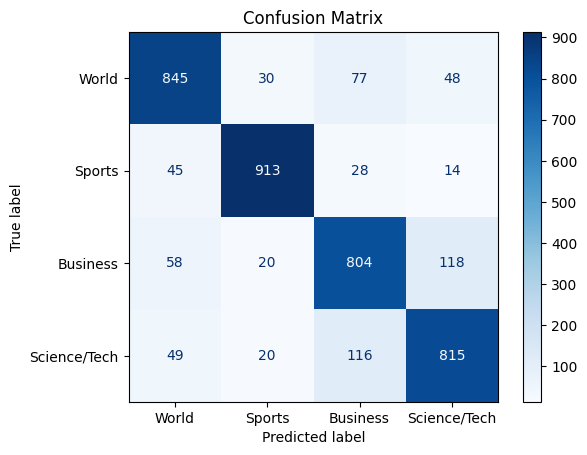

Misclassified Texts:
Predicted: World, Actual: World
Text: reuter larg blast heard central baghdad thursday wit said
--------------------------------------------------
Predicted: World, Actual: World
Text: reuter larg blast heard central baghdad thursday wit said
--------------------------------------------------
Predicted: World, Actual: World
Text: reuter larg blast heard central baghdad thursday wit said
--------------------------------------------------
Predicted: World, Actual: World
Text: reuter larg blast heard central baghdad thursday wit said
--------------------------------------------------
Predicted: World, Actual: World
Text: reuter larg blast heard central baghdad thursday wit said
--------------------------------------------------


In [48]:
# To store final model (trained on full training data during each fold)
for train_index, val_index in kf.split(train_sbert):
    X_train, X_val = train_sbert[train_index], train_sbert[val_index]
    y_train, y_val = train_y[train_index], train_y[val_index]
    
    # Train the model using KFold
    catboost_model.fit(X_train, y_train)

# After training with K-fold, make predictions on the test set
evaluate_model(catboost_model, test_sbert, test_y)

Accuracy is: 0.84875
Classification Report:
              precision    recall  f1-score   support

       World       0.87      0.84      0.86      1000
      Sports       0.92      0.93      0.92      1000
    Business       0.78      0.81      0.80      1000
Science/Tech       0.82      0.81      0.82      1000

    accuracy                           0.85      4000
   macro avg       0.85      0.85      0.85      4000
weighted avg       0.85      0.85      0.85      4000



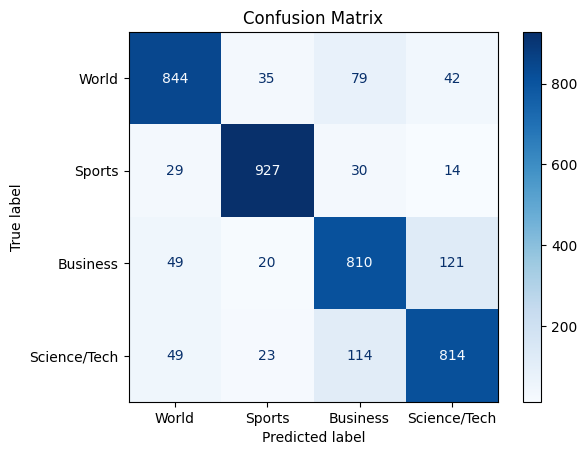

Misclassified Texts:
Predicted: Science/Tech, Actual: World
Text: mep threaten last night bring new european commiss even take offic row spark controversi comment homosexu escal unpreced crisi
--------------------------------------------------
Predicted: Sports, Actual: World
Text: thousand disgruntl vacation strand heathrow airport tuesday british airway cancel score flight staff shortag technic hitch
--------------------------------------------------
Predicted: Business, Actual: World
Text: ankara turkey hope attract  billion foreign invest   reform design overhaul economi eas countri  entri
--------------------------------------------------
Predicted: Sports, Actual: World
Text: hayley mick journalist current base vancouv broadcast experi cbc radio  quirk quark report vancouv sun cbc onlin canadian press  ontario vancouv bureau
--------------------------------------------------
Predicted: Business, Actual: World
Text: kuala lumpur malaysia convey thai prime minist thaksin shinawatra

In [49]:
# To store final model (trained on full training data during each fold)
for train_index, val_index in kf.split(train_sbert):
    X_train, X_val = train_sbert[train_index], train_sbert[val_index]
    y_train, y_val = train_y[train_index], train_y[val_index]
    
    # Train the model using KFold
    voting_clf.fit(X_train, y_train)

# After training with K-fold, make predictions on the test set
evaluate_model(voting_clf, test_sbert, test_y)

### doc2vec

In [50]:
train_doc2vec = np.array(train_doc2vec)
test_doc2vec = np.array(test_doc2vec)

Accuracy is: 0.70975
Classification Report:
              precision    recall  f1-score   support

       World       0.71      0.70      0.71      1000
      Sports       0.80      0.81      0.81      1000
    Business       0.67      0.61      0.64      1000
Science/Tech       0.65      0.72      0.68      1000

    accuracy                           0.71      4000
   macro avg       0.71      0.71      0.71      4000
weighted avg       0.71      0.71      0.71      4000



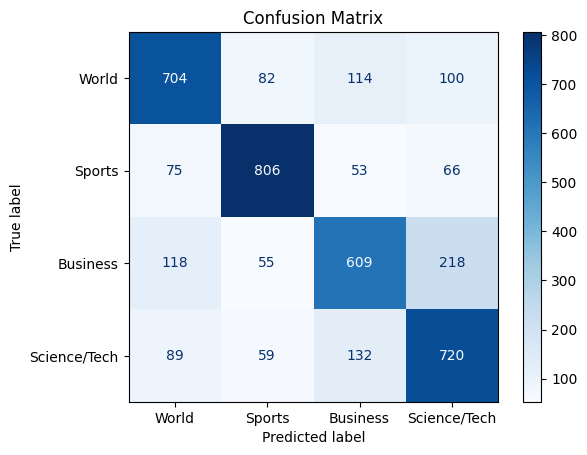

Misclassified Texts:
Predicted: Business, Actual: World
Text: suicid attack deton car bomb near crowd peopl wait appli job iraqi nation guard northern citi kirkuk yesterday kill least  peopl wound  offici said
--------------------------------------------------
Predicted: Science/Tech, Actual: World
Text: near daili attack pipelin pump station push iraq  oil export lowest point nearli year britain  financi time newspap report today
--------------------------------------------------
Predicted: Sports, Actual: World
Text: us iraqi forc battl milit najaf tuesday iraqi nation guardsmen advanc within  yard holi citi  imam ali shrine compound insurg loyal radic cleric muqtada al sadr hole week
--------------------------------------------------
Predicted: Sports, Actual: World
Text: presid bush democrat challeng john f kerri lung final two week  presidenti campaign monday feud feverishli iraq war fight terrorist
--------------------------------------------------
Predicted: Sports, Actual: Worl

In [51]:
# To store final model (trained on full training data during each fold)
for train_index, val_index in kf.split(train_doc2vec):
    X_train, X_val = train_doc2vec[train_index], train_doc2vec[val_index]
    y_train, y_val = train_y[train_index], train_y[val_index]
    
    # Train the model using KFold
    xgb_model.fit(X_train, y_train)

# After training with K-fold, make predictions on the test set
evaluate_model(xgb_model, test_doc2vec, test_y)

Accuracy is: 0.636
Classification Report:
              precision    recall  f1-score   support

       World       0.65      0.66      0.65      1000
      Sports       0.75      0.71      0.73      1000
    Business       0.59      0.52      0.55      1000
Science/Tech       0.57      0.65      0.61      1000

    accuracy                           0.64      4000
   macro avg       0.64      0.64      0.64      4000
weighted avg       0.64      0.64      0.64      4000



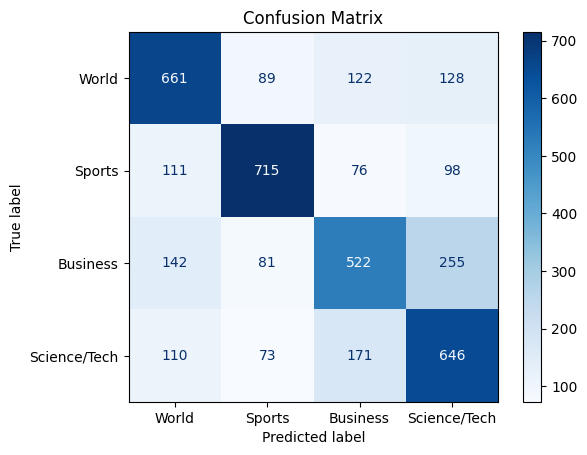

Misclassified Texts:
Predicted: Science/Tech, Actual: World
Text: suicid attack deton car bomb near crowd peopl wait appli job iraqi nation guard northern citi kirkuk yesterday kill least  peopl wound  offici said
--------------------------------------------------
Predicted: Business, Actual: World
Text: soldier withdrew height ossetian capit tskhinvali thursday turn area peacekeep georgia say three soldier kill earlier fight ossetian author say three civilian die
--------------------------------------------------
Predicted: Business, Actual: World
Text: reuter govern warplan helicopt gunship pound rebel held town northern ivori coast second day friday fuel fear slide war world top cocoa grower
--------------------------------------------------
Predicted: Science/Tech, Actual: World
Text: washington gay marriag emerg big enough issu sever state influenc race congress presid ballot initi ban sex marriag expect propel social conserv poll  state includ four presidenti battleground arkansa

In [52]:
# To store final model (trained on full training data during each fold)
for train_index, val_index in kf.split(train_doc2vec):
    X_train, X_val = train_doc2vec[train_index], train_doc2vec[val_index]
    y_train, y_val = train_y[train_index], train_y[val_index]
    
    # Train the model using KFold
    rf_model.fit(X_train, y_train)

# After training with K-fold, make predictions on the test set
evaluate_model(rf_model, test_doc2vec, test_y)

Accuracy is: 0.7235
Classification Report:
              precision    recall  f1-score   support

       World       0.72      0.73      0.73      1000
      Sports       0.82      0.81      0.81      1000
    Business       0.70      0.63      0.66      1000
Science/Tech       0.66      0.73      0.69      1000

    accuracy                           0.72      4000
   macro avg       0.73      0.72      0.72      4000
weighted avg       0.73      0.72      0.72      4000



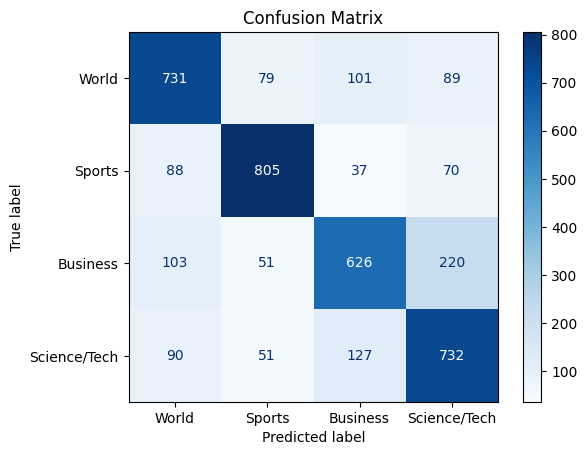

Misclassified Texts:
Predicted: World, Actual: World
Text: reuter larg blast heard central baghdad thursday wit said
--------------------------------------------------
Predicted: World, Actual: World
Text: reuter larg blast heard central baghdad thursday wit said
--------------------------------------------------
Predicted: World, Actual: World
Text: reuter larg blast heard central baghdad thursday wit said
--------------------------------------------------
Predicted: World, Actual: World
Text: reuter larg blast heard central baghdad thursday wit said
--------------------------------------------------
Predicted: World, Actual: World
Text: reuter larg blast heard central baghdad thursday wit said
--------------------------------------------------


In [53]:
# To store final model (trained on full training data during each fold)
for train_index, val_index in kf.split(train_doc2vec):
    X_train, X_val = train_doc2vec[train_index], train_doc2vec[val_index]
    y_train, y_val = train_y[train_index], train_y[val_index]
    
    # Train the model using KFold
    catboost_model.fit(X_train, y_train)

# After training with K-fold, make predictions on the test set
evaluate_model(catboost_model, test_doc2vec, test_y)

Accuracy is: 0.731
Classification Report:
              precision    recall  f1-score   support

       World       0.73      0.72      0.73      1000
      Sports       0.82      0.82      0.82      1000
    Business       0.70      0.64      0.67      1000
Science/Tech       0.67      0.75      0.71      1000

    accuracy                           0.73      4000
   macro avg       0.73      0.73      0.73      4000
weighted avg       0.73      0.73      0.73      4000



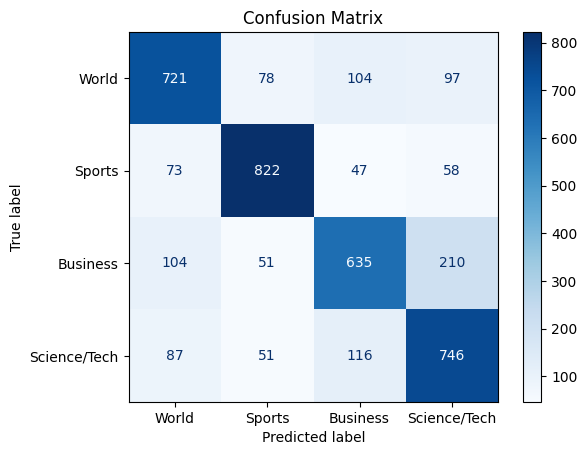

Misclassified Texts:
Predicted: Business, Actual: World
Text: suicid attack deton car bomb near crowd peopl wait appli job iraqi nation guard northern citi kirkuk yesterday kill least  peopl wound  offici said
--------------------------------------------------
Predicted: Science/Tech, Actual: World
Text: near daili attack pipelin pump station push iraq  oil export lowest point nearli year britain  financi time newspap report today
--------------------------------------------------
Predicted: Business, Actual: World
Text: reuter govern warplan helicopt gunship pound rebel held town northern ivori coast second day friday fuel fear slide war world top cocoa grower
--------------------------------------------------
Predicted: Sports, Actual: World
Text: presid bush democrat challeng john f kerri lung final two week  presidenti campaign monday feud feverishli iraq war fight terrorist
--------------------------------------------------
Predicted: Business, Actual: World
Text: pakistani forc b

In [54]:
# To store final model (trained on full training data during each fold)
for train_index, val_index in kf.split(train_doc2vec):
    X_train, X_val = train_doc2vec[train_index], train_doc2vec[val_index]
    y_train, y_val = train_y[train_index], train_y[val_index]
    
    # Train the model using KFold
    voting_clf.fit(X_train, y_train)

# After training with K-fold, make predictions on the test set
evaluate_model(voting_clf, test_doc2vec, test_y)